In [1]:
import os
os.environ['TRKXINPUTDIR']="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all"
os.environ['TRKXOUTPUTDIR']= "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/outtest" 

In [2]:
import pickle
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import warnings
warnings.filterwarnings('ignore')
from os import listdir
from os.path import isfile, join


sys.path.append('/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/')

# 3rd party
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from trackml.dataset import load_event
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


# local import
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir
from exatrkx.src import utils_robust
from utils_robust import *


# for preprocessing
from exatrkx import FeatureStore
from exatrkx.src import utils_torch

# for embedding
from exatrkx import LayerlessEmbedding
from exatrkx.src import utils_torch
from torch_cluster import radius_graph
from utils_torch import build_edges
from embedding.embedding_base import *

# for filtering
from exatrkx import VanillaFilter

# for GNN
import tensorflow as tf
from graph_nets import utils_tf
from exatrkx import SegmentClassifier
import sonnet as snt

# for labeling
from exatrkx.scripts.tracks_from_gnn import prepare as prepare_labeling
from exatrkx.scripts.tracks_from_gnn import clustering as dbscan_clustering

# track efficiency
from trackml.score import _analyze_tracks
from exatrkx.scripts.eval_reco_trkx import make_cmp_plot, pt_configs, eta_configs,get_ratio,pairwise
from functools import partial

In [3]:
noise_keep = ["0.2", "0.4", "0.6", "0.8", "1"]
embed_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
filter_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
gnn_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/gnn'
plots_dir = '/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/plots/run1000' # needs to change...
ckpt_idx = -1 # which GNN checkpoint to load
dbscan_epsilon, dbscan_minsamples = 0.25, 2 # hyperparameters for DBScan
min_hits = 5 # minimum number of hits associated with a particle to define "reconstructable particles"
frac_reco_matched, frac_truth_matched = 0.5, 0.5 # parameters for track matching

In [4]:
def open_pickle(pickle_dir):
    with open(pickle_dir, 'rb') as handle:
        unpickler = pickle.Unpickler(handle)
        b = unpickler.load()
    return b

In [5]:
noise_keep = ['0','0.2','0.4','0.6','0.8','1']
plt.rcParams.update({'font.size': 18, 'axes.labelsize' : 18})
noise_labels = [f'{float(n)*0.2*100:.0f}' for n in noise_keep]

In [6]:
plt.rcParams.update({'axes.titlesize' : 16, 'axes.labelsize' : 16, 'lines.linewidth' : 2, 'lines.markersize' : 10,
                    'xtick.labelsize' : 14, 'xtick.major.width' : 2,
                    'ytick.labelsize' : 14, 'ytick.major.width' : 2,
                    'grid.alpha' : 0.5, "legend.frameon" : False, 'legend.fontsize' : 16})

In [7]:
list_data = {}
bperc = []
fperc = []
eperc = []
tperc = []
btimes = []
atimes = []
ttimes = []

for n in noise_keep:
    pickle_dir = f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/lists_n{n}.pickle'
    list_data[f'{n}'] = open_pickle(pickle_dir)
    
    d = list_data[f'{n}']
    
    all_times = d['all_steps']
    all_times = np.mean(all_times)
    atimes.append(all_times)
    
    total_times = d['total_time']
    ttimes.append(total_times)
    
    build = np.mean(d['avg_build_time'])
    build_perc = (build/all_times) * 100
    bperc.append(build_perc)
    btimes.append(build)
    
    esp = np.mean(d['esp_times'])
    esp_perc = (esp/all_times) * 100
    eperc.append(esp_perc)
    
    trkeff = np.mean(d['trkeff_times'])
    trkeff_perc = (trkeff/all_times) * 100
    tperc.append(trkeff_perc)
    
    f = np.mean(d['f_times'])
    f_perc = (f/all_times) * 100
    fperc.append(f_perc)

No handles with labels found to put in legend.


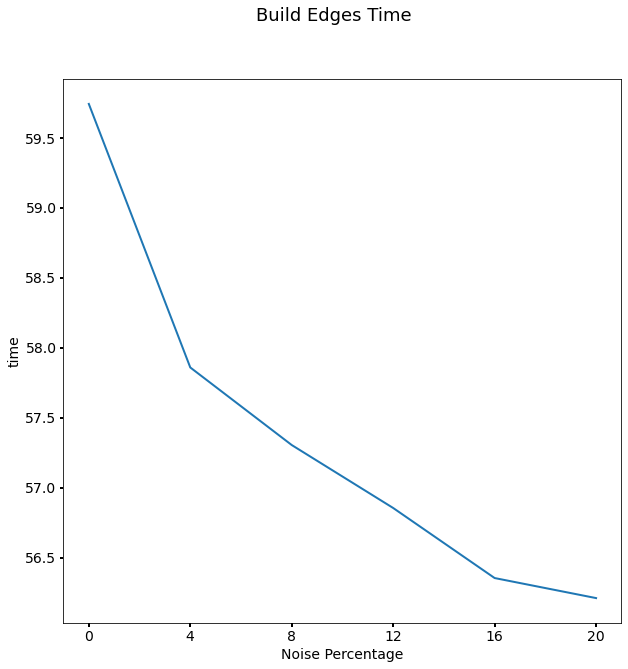

In [8]:
fig1,ax1 = plt.subplots(figsize = (10,10))
x = np.arange(len(noise_keep))

ax1.plot(x,eperc)

ax1.set_xlabel('Noise Percentage', fontsize=14)
ax1.set_ylabel('time', fontsize=14)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
fig1.suptitle('Build Edges Time', fontsize=18)
ax1.set_xticks(x)
ax1.set_xticklabels(noise_labels)
ax1.legend()

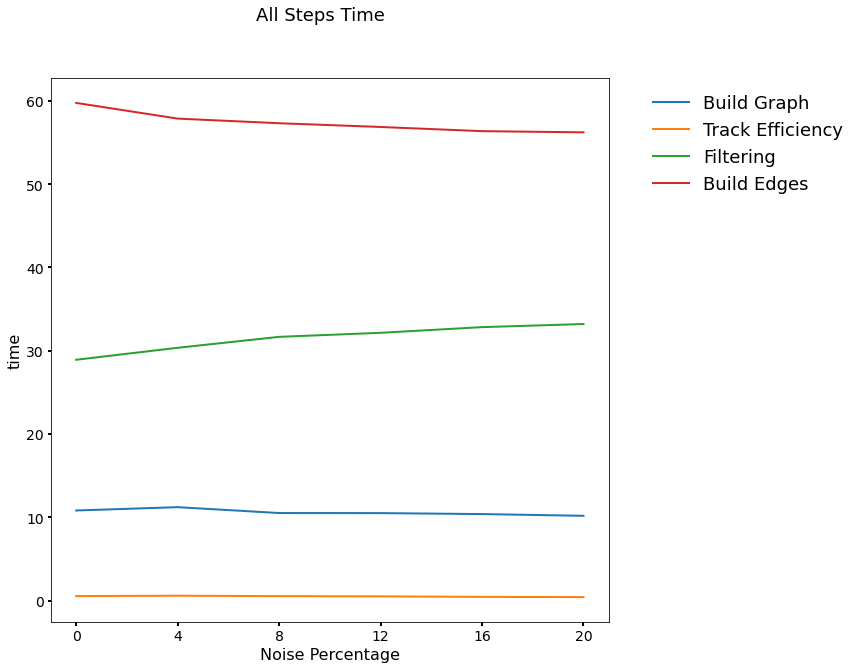

In [9]:
fig2,ax2 = plt.subplots(figsize = (10,10))
x = np.arange(len(noise_keep))
plt.rcParams.update({'font.size': 14, 'axes.labelsize' : 14})

ax2.plot(x,bperc, label='Build Graph')
ax2.plot(x,tperc, label='Track Efficiency')
ax2.plot(x,fperc, label='Filtering')
ax2.plot(x,eperc, label='Build Edges')

ax2.set_xlabel('Noise Percentage')
ax2.set_ylabel('time')
plt.rc('xtick')
plt.rc('ytick')
fig2.suptitle('All Steps Time', fontsize=18)
ax2.set_xticks(x)
ax2.set_xticklabels(noise_labels)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18)

In [10]:
def mcp(xarray, yarray, xlegend, ylegend, configs, xlabel, ylabel, ratio_label, ax1, ax2):
    
    m_vals, bins, _ = ax1.hist(xarray, **configs, label=xlegend)
    n_vals, _, _ = ax1.hist(yarray, **configs, label=ylegend)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.legend()
    

    ratio, ratio_err = get_ratio(m_vals, n_vals)
    xvals = [0.5*(x[1]+x[0]) for x in pairwise(bins)][1:]
    xerrs = [0.5*(x[1]-x[0]) for x in pairwise(bins)][1:]
    # print(xvals)
    ax2.errorbar(xvals, ratio, yerr=ratio_err, fmt='o', xerr=xerrs, lw=2)
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ratio_label)
    ax2.set_yticks(np.arange(0.5, 1.05, step=0.05))
    ax2.set_ylim(0.5, 1.05)
    ax2.grid(True)
    ax2.legend(fontsize=14)
    # ax.text(1, 0.8, "bins: [{}] GeV".format(", ".join(["{:.1f}".format(x) for x in pt_bins[1:]]))
    return xvals,ratio, xerrs, ratio_err

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


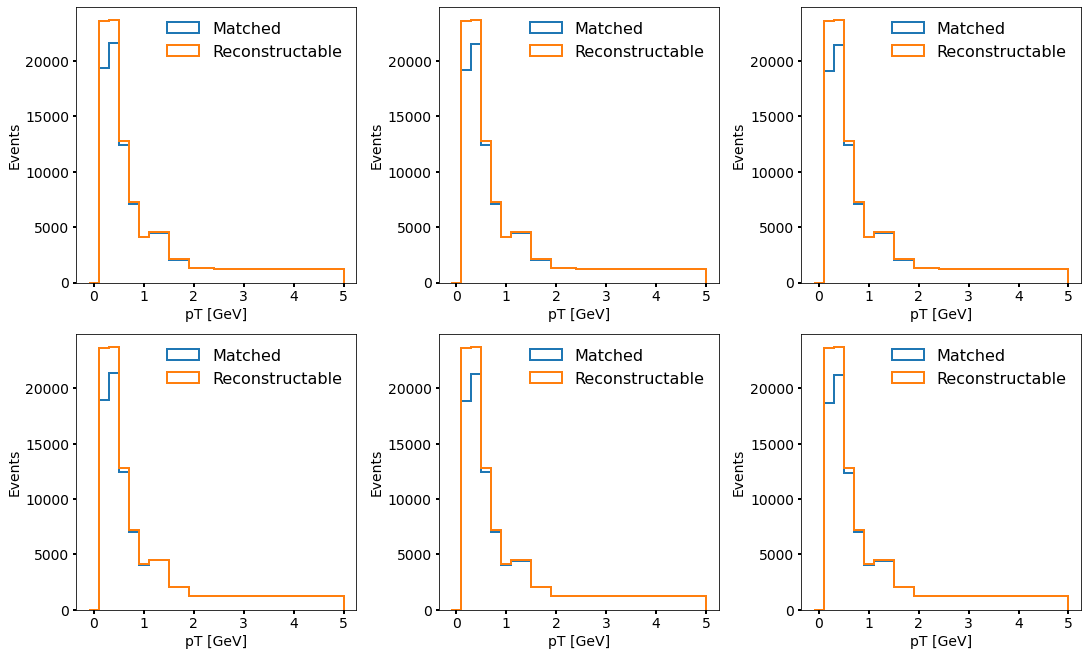

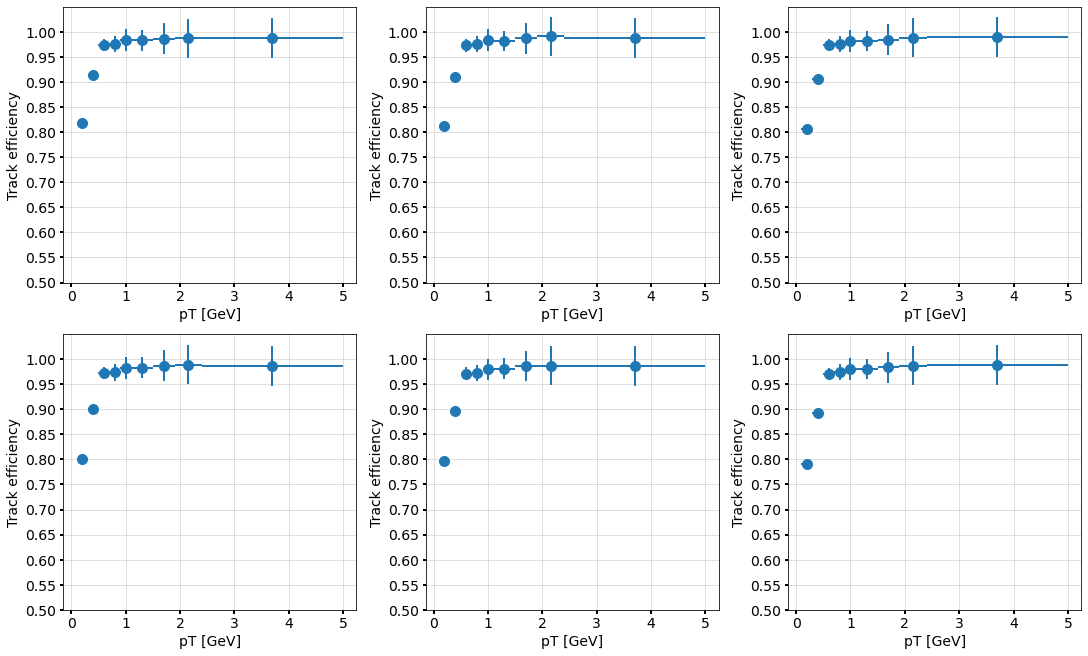

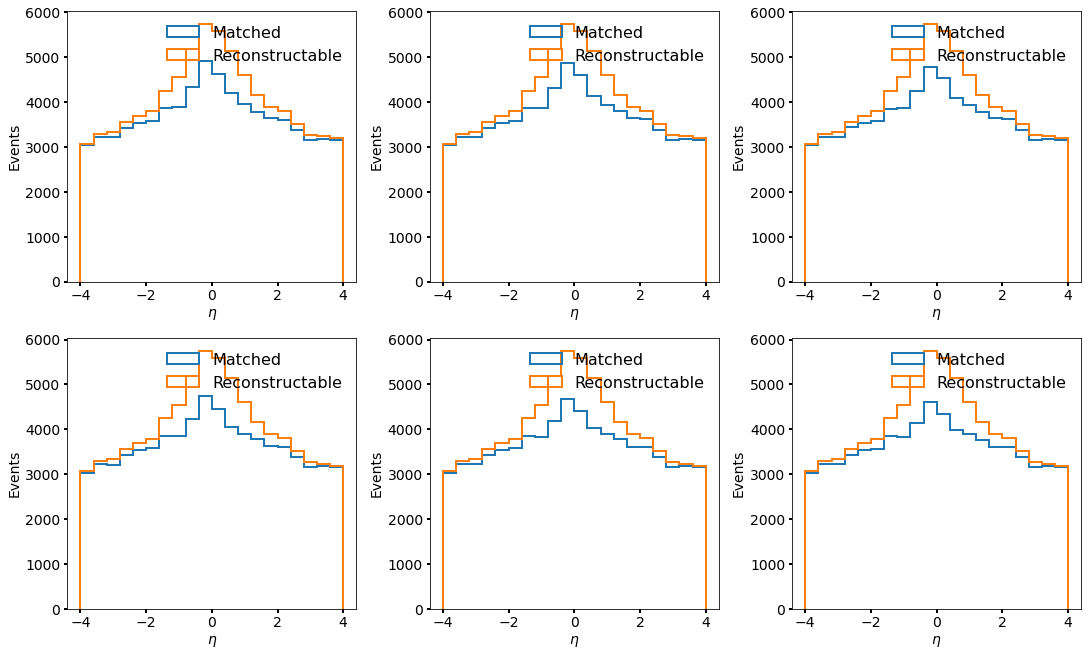

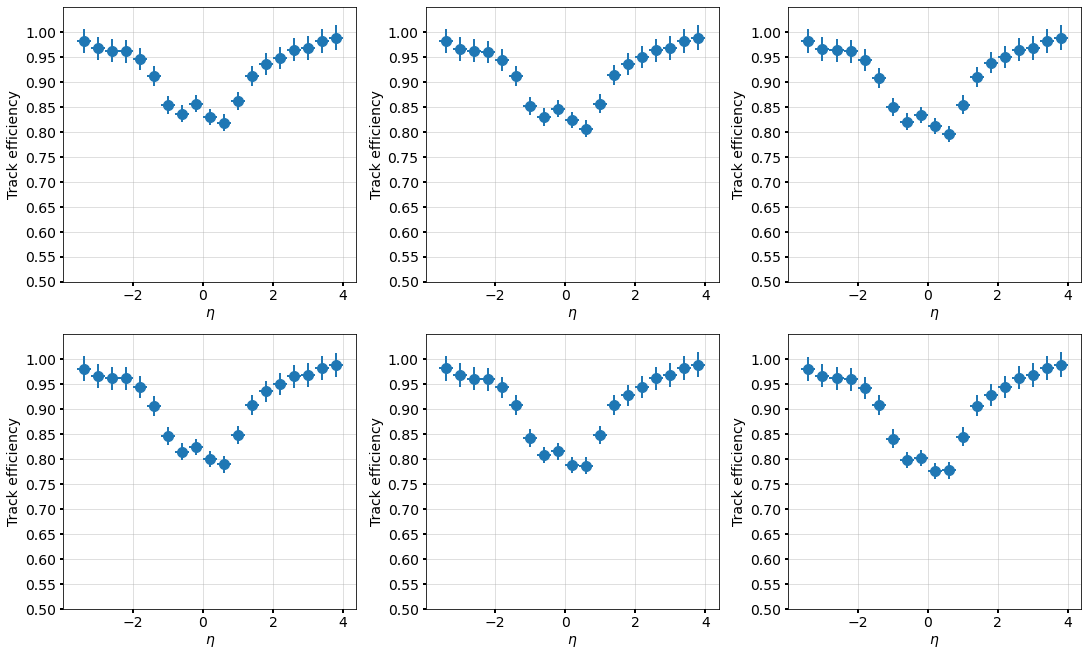

In [11]:
# axes2[i//3][i%3]
fig3, ax3 = plt.subplots(2,3, figsize = (15,9),constrained_layout=True)
fig4, ax4 = plt.subplots(2,3, figsize = (15,9),constrained_layout=True)
fig5, ax5 = plt.subplots(2,3, figsize = (15,9),constrained_layout=True)
fig6, ax6 = plt.subplots(2,3, figsize = (15,9),constrained_layout=True)
plt.rcParams.update({'font.size': 14, 'axes.labelsize' : 14})

xvals_ppt = []
xvals_pt = []
yvals_ppt = []
yvals_pt = []
xerrpt = []
yerrpt = []
xerrppt =[]
yerrppt = []


for i,n in enumerate(noise_keep):
    d = list_data[f'{n}']
    midx = np.concatenate(d['matched_idx'], axis=0)
    pt = np.concatenate(d['peta'], axis=0)
    ppt = np.concatenate(d['par_pt'], axis=0)
    
    make_cmp_plot_fn = partial(mcp, 
                               xlegend="Matched", 
                               ylegend="Reconstructable", 
                               ylabel="Events", 
                               ratio_label='Track efficiency')
    
    x_ppt,y_ppt,xeppt,yeppt = make_cmp_plot_fn(ppt[midx], ppt,
                 configs=pt_configs,
                 xlabel="pT [GeV]",ax1=ax3[i//3][i%3],ax2=ax4[i//3][i%3])
    xvals_ppt.append(x_ppt)
    yvals_ppt.append(y_ppt)
    xerrppt.append(xeppt)
    yerrppt.append(yeppt)
    
    x_pt,y_pt,xept,yept = make_cmp_plot_fn(pt[midx], pt,
                 configs=eta_configs,
                 xlabel=r"$\eta$", ax1=ax5[i//3][i%3],ax2=ax6[i//3][i%3])
    xvals_pt.append(x_pt)
    yvals_pt.append(y_pt)
    xerrpt.append(xept)
    yerrpt.append(yept)
    
    plt.legend()

In [12]:
x_ppt = np.array(xvals_ppt[0])
y_ppt_nn = np.array(yvals_ppt[0])
x_pt = np.array(xvals_pt[0])
y_pt_nn = np.array(yvals_pt[0])
xept0 = np.array(xerrpt[0])
yept0 = np.array(yerrpt[0])
xeppt0 = np.array(xerrppt[0])
yeppt0 = np.array(yerrppt[0])
pt_ratios = []
ppt_ratios = []
xerrprop_pt = []
yerrprop_pt = []
xerrprop_ppt = []
yerrprop_ppt = []


for j in range(0,len(xvals_ppt)):
    x_pt_n = np.array(xvals_pt[j])
    x_ppt_n = np.array(xvals_ppt[j])
    
    y_ppt_n = np.array(yvals_ppt[j])
    y_pt_n = np.array(yvals_pt[j])
    
    ptr = y_pt_n/y_pt_nn
    pptr = y_ppt_n/y_ppt_nn
    
    xeptn = np.array(xerrpt[j])
    yeptn = np.array(yerrpt[j])
    xepptn = np.array(xerrppt[j])
    yepptn = np.array(yerrppt[j])
    
    xept = np.sqrt((xept0/x_pt)**2 + (xeptn/x_pt_n)**2)
    xeppt = np.sqrt((xeppt0/x_ppt)**2 + (xepptn/x_ppt_n)**2)
    yept = np.sqrt((yept0/y_pt)**2 + (yeptn/ptr)**2)
    yeppt = np.sqrt((yeppt0/y_ppt)**2 + (yepptn/pptr)**2)
    
    pt_ratios.append(ptr)
    ppt_ratios.append(pptr)
    xerrprop_pt.append(xept)
    yerrprop_pt.append(yept)
    xerrprop_ppt.append(xeppt)
    yerrprop_ppt.append(yeppt)

Text(0, 0.5, 'Ratio of Track Efficiencies')

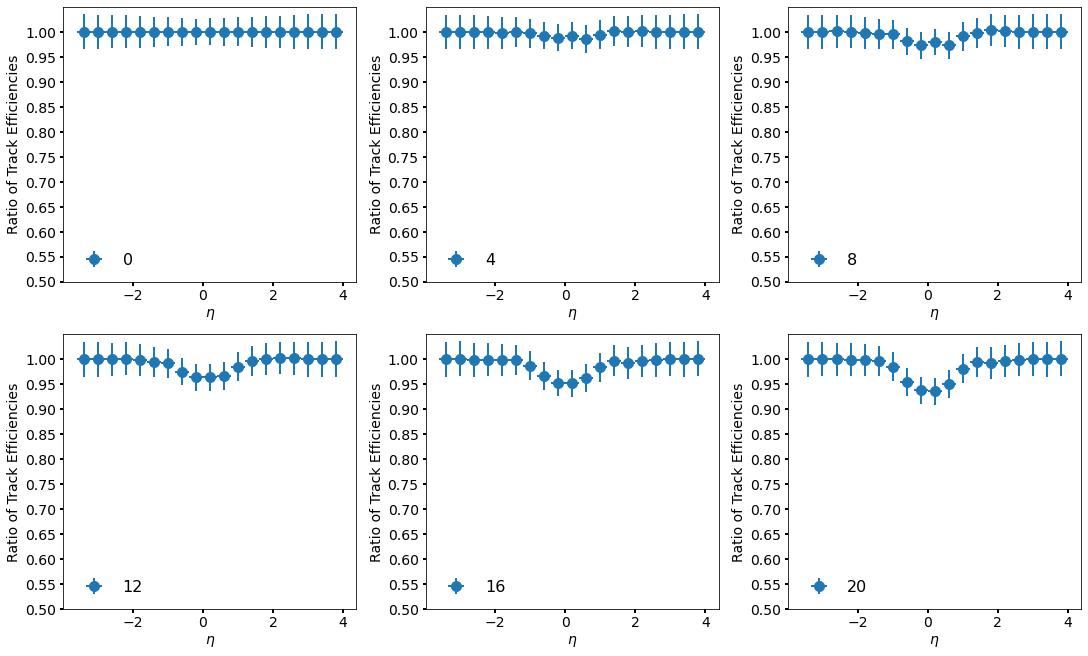

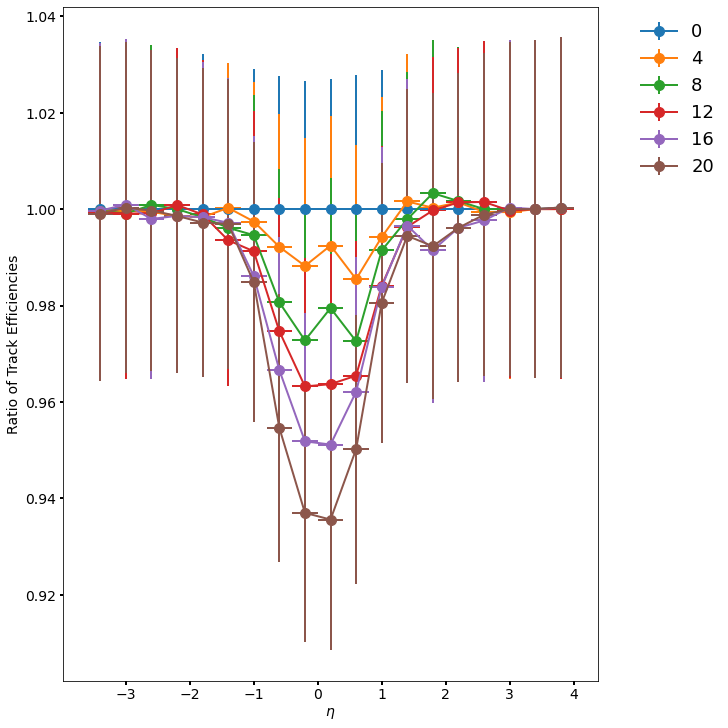

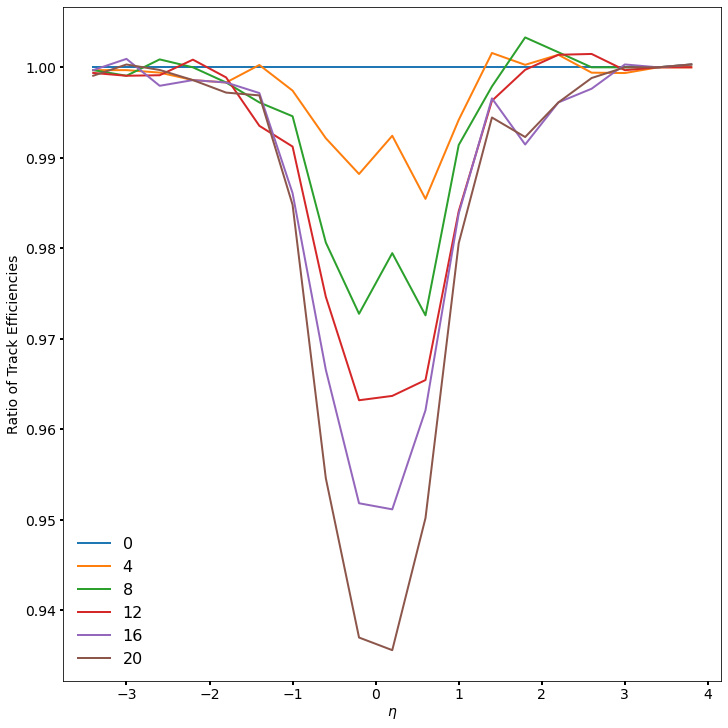

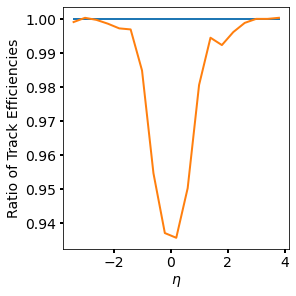

In [14]:
fig7 ,ax7 = plt.subplots(2,3, figsize = (15,9),constrained_layout=True)
fig8 ,ax8 = plt.subplots(1,1, figsize = (10,10),constrained_layout=True)
fig9 ,ax9 = plt.subplots(1,1, figsize = (10,10),constrained_layout=True)



for xx, yy, xe, ye, nn in zip(xvals_pt, pt_ratios, xerrpt, yerrprop_pt, enumerate(noise_keep)):
#     print("=====")
#     print(len(xx),len(yy), len(xe), len(ye))
    label = f'{float(nn[1])*0.2*100:.0f}'
    ax7[nn[0]//3][nn[0]%3].errorbar(xx, yy, xerr = xe, yerr = ye, fmt='o', lw=2, label=label)
    ax8.errorbar(xx, yy, xerr = xe, yerr = ye, fmt='-o', lw=2, label=label)
    ax9.plot(xx,yy,label=label)
    ax9.set_xlabel(r"$\eta$")
    ax9.set_ylabel('Ratio of Track Efficiencies')
    ax8.set_xlabel(r"$\eta$")
    ax8.set_ylabel('Ratio of Track Efficiencies')
    ax7[nn[0]//3][nn[0]%3].set_xlabel(r"$\eta$")
    ax7[nn[0]//3][nn[0]%3].set_ylabel('Ratio of Track Efficiencies')
    ax7[nn[0]//3][nn[0]%3].set_yticks(np.arange(0.5, 1.05, step=0.05))
    ax7[nn[0]//3][nn[0]%3].set_ylim(0.5, 1.05)
    ax7[nn[0]//3][nn[0]%3].legend()
    ax8.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18)
    ax9.legend()

fig ,ax = plt.subplots(1,1, figsize = (4,4),constrained_layout=True)
ax.plot(xvals_pt[0],pt_ratios[0],label='0')
ax.plot(xvals_pt[5],pt_ratios[5],label='20')
ax.set_xlabel(r"$\eta$")
ax.set_ylabel('Ratio of Track Efficiencies')

Text(0, 0.5, 'Ratio of Track Efficiencies')

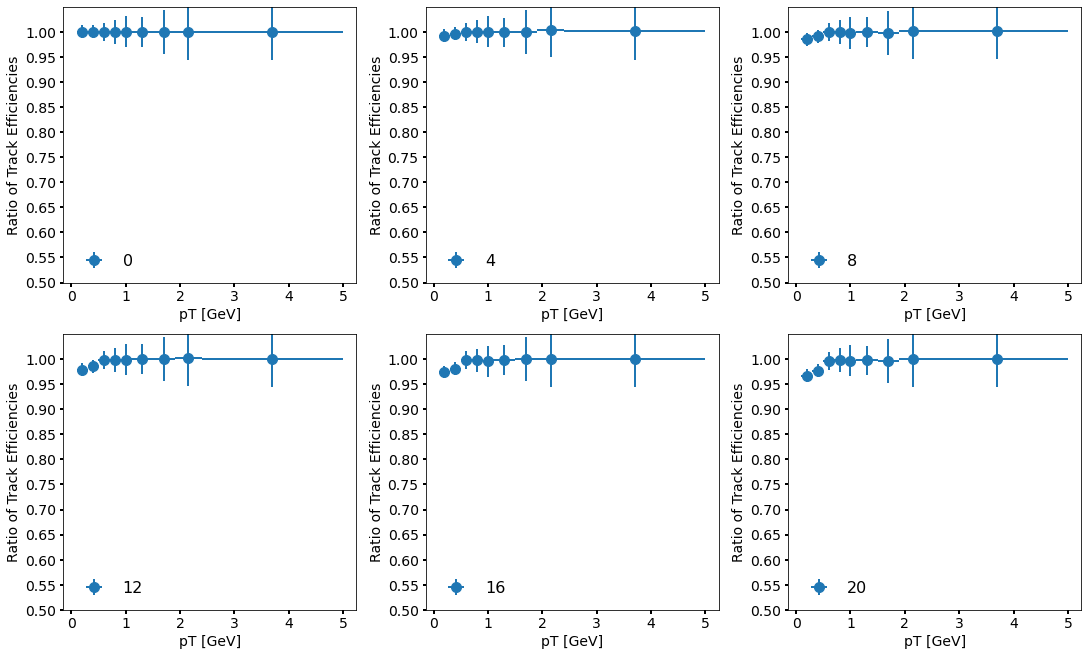

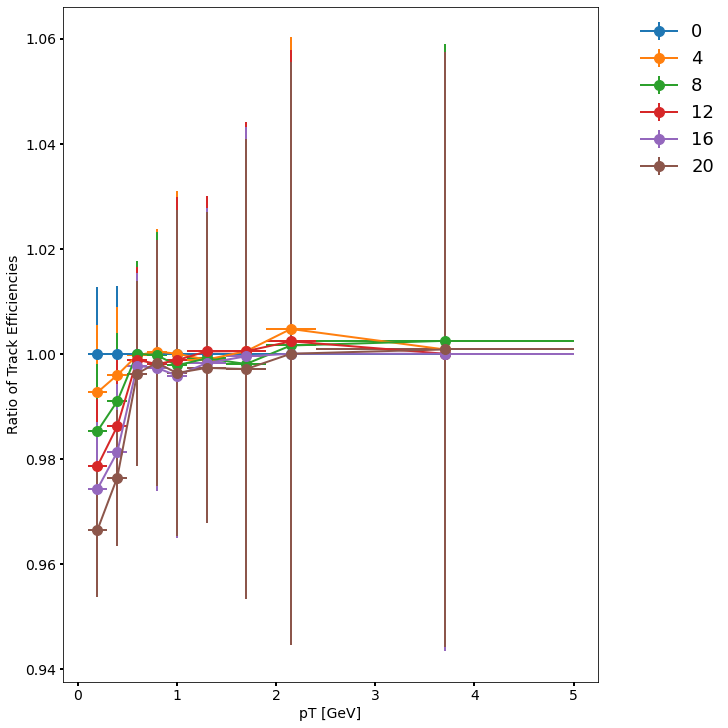

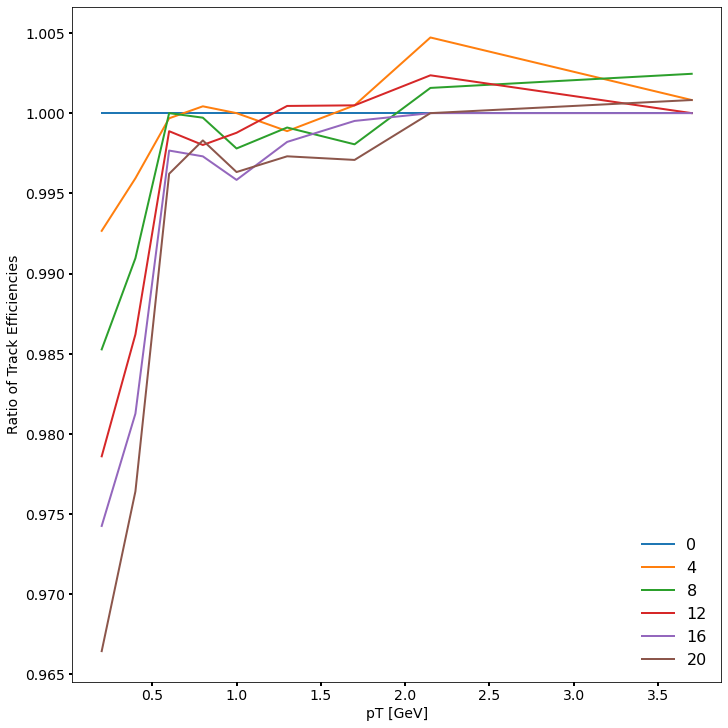

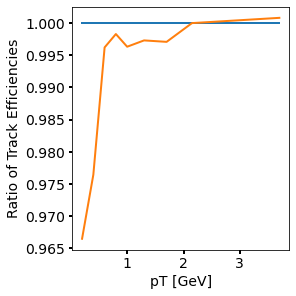

In [15]:
fig10 ,ax10 = plt.subplots(2,3, figsize = (15,9),constrained_layout=True)
fig11 ,ax11 = plt.subplots(1,1, figsize = (10,10),constrained_layout=True)
fig12 ,ax12 = plt.subplots(1,1, figsize = (10,10),constrained_layout=True)



for xx, yy, xe, ye, nn in zip(xvals_ppt, ppt_ratios, xerrppt, yerrprop_ppt, enumerate(noise_keep)):
    label = f'{float(nn[1])*0.2*100:.0f}'
    ax10[nn[0]//3][nn[0]%3].errorbar(xx, yy, xerr = xe, yerr = ye, fmt='o', lw=2, label=label)
    ax11.errorbar(xx, yy, xerr = xe, yerr = ye, fmt='-o', lw=2, label=label)
    ax12.plot(xx,yy,label=label)
    ax12.set_xlabel("pT [GeV]")
    ax12.set_ylabel('Ratio of Track Efficiencies')
    ax11.set_xlabel("pT [GeV]")
    ax11.set_ylabel('Ratio of Track Efficiencies')
    ax10[nn[0]//3][nn[0]%3].set_xlabel("pT [GeV]")
    ax10[nn[0]//3][nn[0]%3].set_ylabel('Ratio of Track Efficiencies')
    ax10[nn[0]//3][nn[0]%3].set_yticks(np.arange(0.5, 1.05, step=0.05))
    ax10[nn[0]//3][nn[0]%3].set_ylim(0.5, 1.05)
    ax10[nn[0]//3][nn[0]%3].legend(loc='lower left')
    ax11.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18)
    ax12.legend()

fig ,ax = plt.subplots(1,1, figsize = (4,4),constrained_layout=True)
ax.plot(xvals_ppt[0],ppt_ratios[0],label='0')
ax.plot(xvals_ppt[5],ppt_ratios[5],label='20')
ax.set_xlabel("pT [GeV]")
ax.set_ylabel('Ratio of Track Efficiencies')

In [16]:
pt_configs_r = {
    'bins': 1,
    'histtype': 'step',
    'lw': 2,
    'log': False}

eta_configs_r = {
    'bins': 1,
    'histtype': 'step',
    'lw': 2,
    'log': False}


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


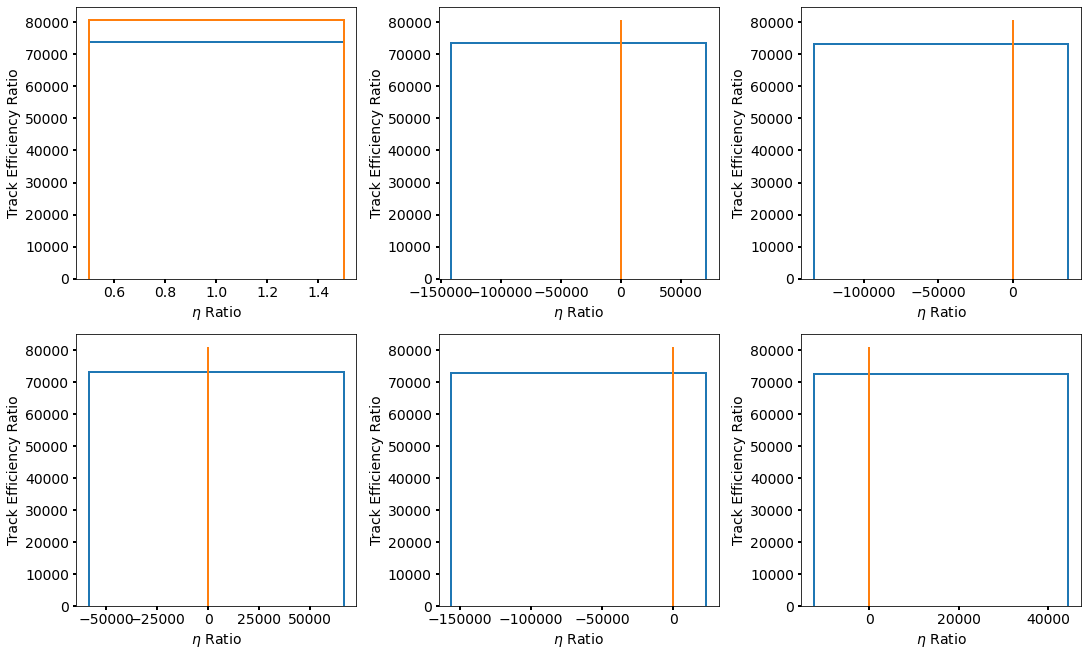

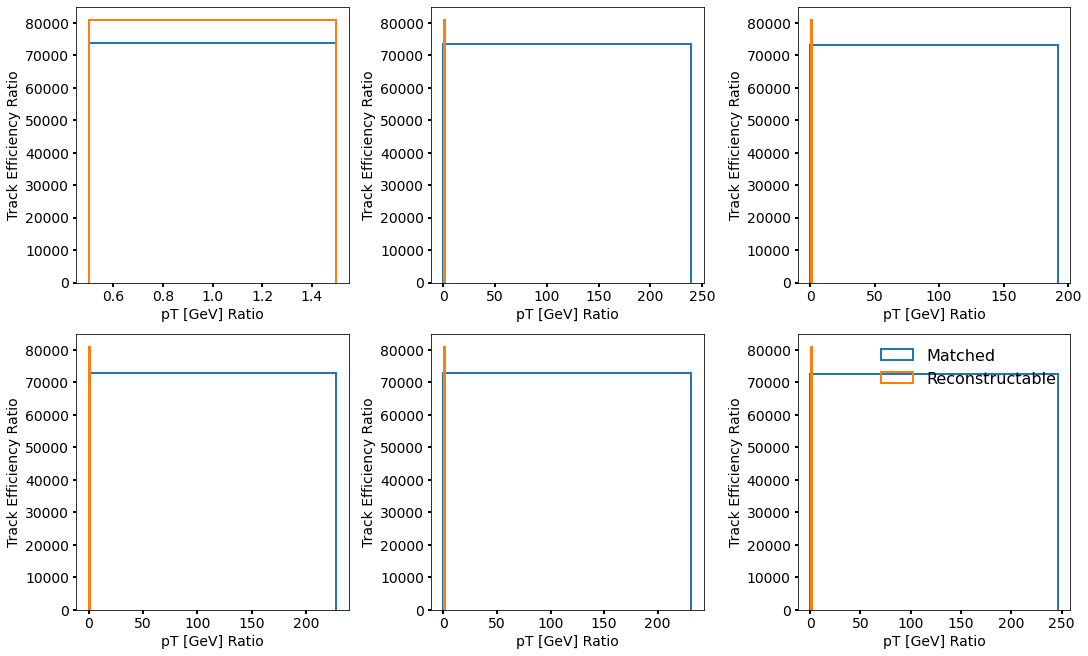

In [17]:
midx0 = np.concatenate(list_data['0']['matched_idx'],axis=0)
ppt0 = np.concatenate(list_data['0']['par_pt'],axis=0)
pt0 = np.concatenate(list_data['0']['peta'], axis=0)

fig13 ,ax13 = plt.subplots(2,3, figsize = (15,9),constrained_layout=True)
fig14 ,ax14 = plt.subplots(2,3, figsize = (15,9),constrained_layout=True)


for i,n in enumerate(noise_keep):
    d = list_data[f'{n}']
    midx = np.concatenate(d['matched_idx'], axis=0)
    pt = np.concatenate(d['peta'], axis=0)
    ppt = np.concatenate(d['par_pt'], axis=0)
    
    xrppt = ppt[midx] / ppt0[midx0][:len(ppt[midx])]
    yrppt = ppt / ppt0
    
    xrpt = pt[midx] / pt0[midx0][:len(pt[midx])]
    yrpt = pt / pt0
    
    ax13[i//3][i%3].hist(xrpt,**eta_configs_r, label="Matched") 
    ax13[i//3][i%3].hist(yrpt,**eta_configs_r, label="Reconstructable")
    ax13[i//3][i%3].set_xlabel(r"$\eta$ Ratio")
    ax13[i//3][i%3].set_ylabel('Track Efficiency Ratio')
    
    ax14[i//3][i%3].hist(xrppt,**pt_configs_r, label="Matched")
    ax14[i//3][i%3].hist(yrppt,**pt_configs_r, label="Reconstructable")
    ax14[i//3][i%3].set_xlabel("pT [GeV] Ratio")
    ax14[i//3][i%3].set_ylabel('Track Efficiency Ratio')
    
    plt.legend()
plt.legend()

In [18]:
pt_bins = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.5, 1.9, 2.4, 5]
pt_configs_r = {
    'bins': pt_bins,
    'histtype': 'step',
    'lw': 2,
    'log': False
}
eta_bins = np.arange(-4, 4.4, step=0.4)
eta_configs_r = {
    'bins': eta_bins,
    'histtype': 'step',
    'lw': 2,
    'log': False
}


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


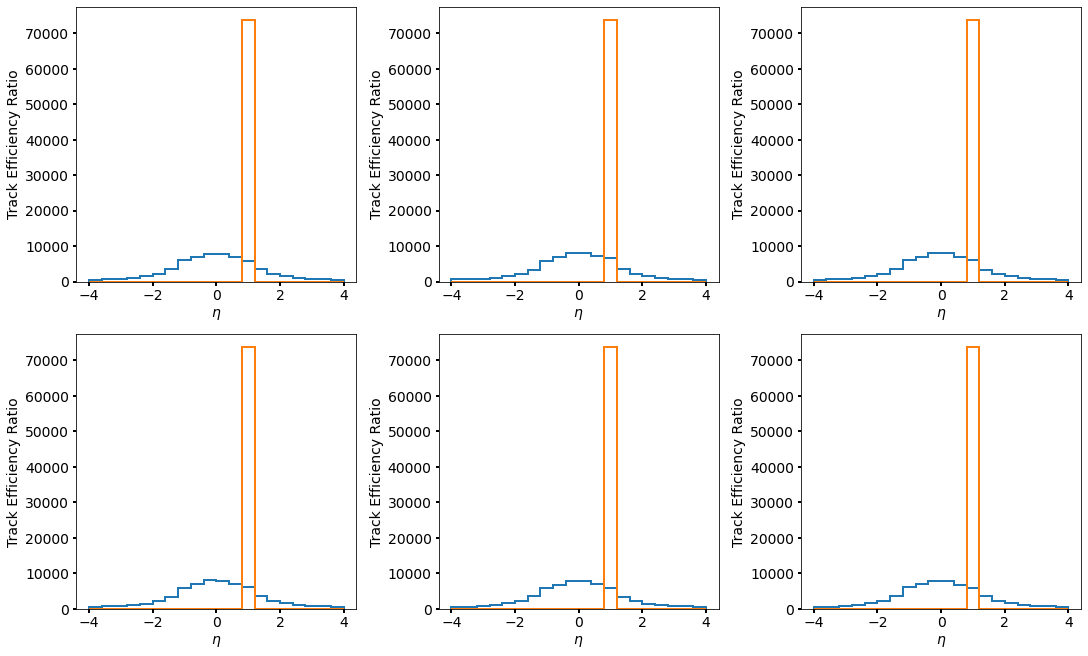

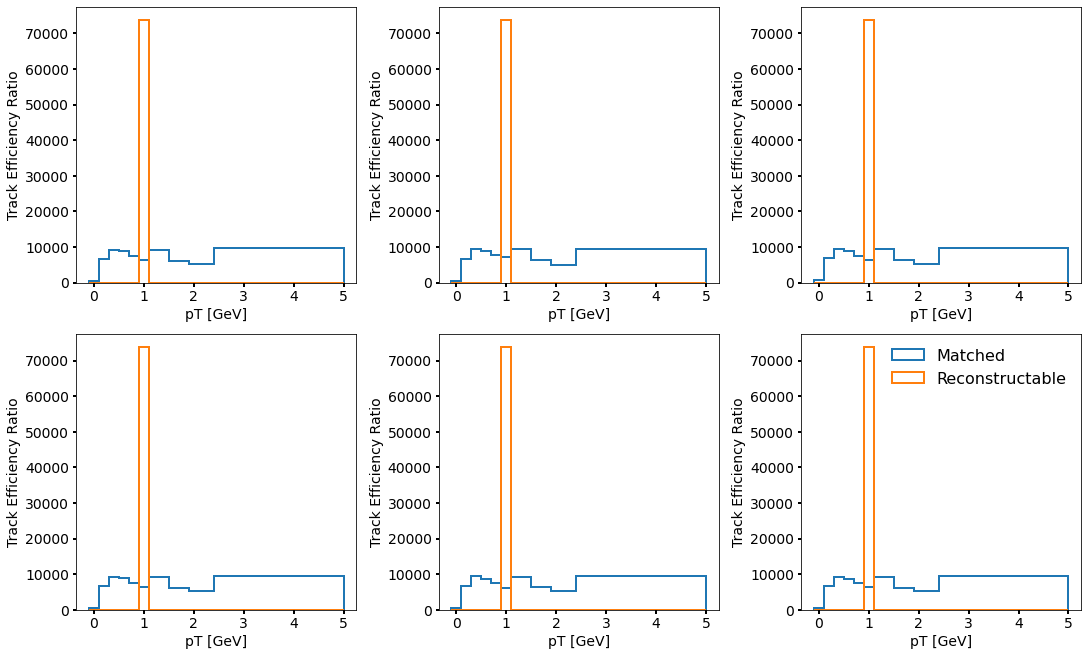

In [19]:
midx0 = np.concatenate(list_data['0']['matched_idx'],axis=0)
ppt0 = np.concatenate(list_data['0']['par_pt'],axis=0)
pt0 = np.concatenate(list_data['0']['peta'], axis=0)

fig13 ,ax13 = plt.subplots(2,3, figsize = (15,9),constrained_layout=True)
fig14 ,ax14 = plt.subplots(2,3, figsize = (15,9),constrained_layout=True)


for i,n in enumerate(noise_keep):
    d = list_data[f'{n}']
    midx = np.concatenate(d['matched_idx'], axis=0)
    pt = np.concatenate(d['peta'], axis=0)
    ppt = np.concatenate(d['par_pt'], axis=0)
    
    if len(ppt[midx]) < len(ppt0[midx0]):
        xrppt = ppt[midx] / ppt0[midx0][:len(ppt[midx])]
    else:
        yrppt = ppt[midx][:len(ppt0[midx0])] / ppt0[midx0]
    if len(pt[midx]) < len(pt0[midx0]):
        xrpt = pt[midx] / pt0[midx0][:len(pt[midx])]
    else:
        yrpt = pt[midx][:len(pt0[midx0])] / pt0[midx0]

    
    ax13[i//3][i%3].hist(xrpt,**eta_configs_r, label="Matched") 
    ax13[i//3][i%3].hist(yrpt,**eta_configs_r, label="Reconstructable")
    ax13[i//3][i%3].set_xlabel(r"$\eta$")
    ax13[i//3][i%3].set_ylabel('Track Efficiency Ratio')
    
    ax14[i//3][i%3].hist(xrppt,**pt_configs_r, label="Matched")
    ax14[i//3][i%3].hist(yrppt,**pt_configs_r, label="Reconstructable")
    ax14[i//3][i%3].set_xlabel("pT [GeV]")
    ax14[i//3][i%3].set_ylabel('Track Efficiency Ratio')
    
    plt.legend()
plt.legend()